# Crypto Prediction with Keras LSTM


## Imports


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os
from math import sqrt
import math, time
from sklearn.metrics import mean_squared_error

## Fetching and Manipulating Crypto Candles

In [2]:
def mapCandles(candle):
    arr = [candle[0], float(candle[1]), float(candle[2]), float(candle[3]), float(candle[4]), float(candle[5]), (float(candle[1]) / float(candle[4]) - 1) * 100, float(candle[8])]
    return arr

In [3]:
symbol = 'ETHUSDT'
period = '4h'
limit = 1000
look_back = 15
result = requests.get('https://api.binance.com/api/v1/klines?limit='+str(limit)+'&symbol='+symbol+'&interval='+period)
candles = list(map(mapCandles, result.json()))
df=pd.DataFrame(candles,columns=["timestamp","open","high","low","close","volume","percent","trades"])
df.head()

,timestamp,open,high,low,close,volume,percent,trades
0,1642377600000,3346.89,3357.57,3256.01,3258.22,53176.1699,2.721425,106052.0
1,1642392000000,3258.22,3299.95,3237.16,3270.70,48883.3746,-0.381570,122521.0
2,1642406400000,3270.71,3281.70,3251.00,3255.94,33598.8201,0.453632,88639.0
3,1642420800000,3255.94,3280.60,3221.00,3236.65,45912.2920,0.595987,109813.0
4,1642435200000,3236.65,3246.76,3180.13,3218.96,55796.8301,0.549556,111623.0


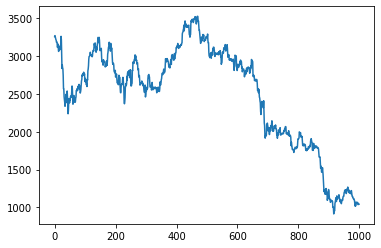

In [4]:
plt.plot(df['close'])
plt.show()

In [5]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = min_max_scaler.fit_transform(df['close'].values.reshape(-1, 1))
dataset[0:5]

array([[0.89711614],
       [0.90189449],
       [0.89624318],
       [0.88885741],
       [0.88208425]])

## Test and Train Data

In [6]:
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print('Train size:', len(train), '- Test size:',len(test))

Train size: 750 - Test size: 250


In [7]:
def create_dataset(dataset, look_back=15):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [8]:
x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [9]:
model = Sequential()
model.add(LSTM(20, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
734/734 - 6s - loss: 0.0105 - 6s/epoch - 8ms/step
Epoch 2/50
734/734 - 2s - loss: 0.0016 - 2s/epoch - 3ms/step
Epoch 3/50
734/734 - 2s - loss: 0.0012 - 2s/epoch - 3ms/step
Epoch 4/50
734/734 - 2s - loss: 9.5871e-04 - 2s/epoch - 3ms/step
Epoch 5/50
734/734 - 2s - loss: 7.9205e-04 - 2s/epoch - 3ms/step
Epoch 6/50
734/734 - 2s - loss: 7.7424e-04 - 2s/epoch - 3ms/step
Epoch 7/50
734/734 - 3s - loss: 8.4268e-04 - 3s/epoch - 3ms/step
Epoch 8/50
734/734 - 3s - loss: 7.3711e-04 - 3s/epoch - 4ms/step
Epoch 9/50
734/734 - 3s - loss: 6.8256e-04 - 3s/epoch - 4ms/step
Epoch 10/50
734/734 - 2s - loss: 6.7292e-04 - 2s/epoch - 3ms/step
Epoch 11/50
734/734 - 2s - loss: 6.8062e-04 - 2s/epoch - 3ms/step
Epoch 12/50
734/734 - 2s - loss: 6.4933e-04 - 2s/epoch - 2ms/step
Epoch 13/50
734/734 - 1s - loss: 6.4436e-04 - 1s/epoch - 2ms/step
Epoch 14/50
734/734 - 1s - loss: 6.8941e-04 - 1s/epoch - 2ms/step
Epoch 15/50
734/734 - 1s - loss: 6.5347e-04 - 1s/epoch - 2ms/step
Epoch 16/50
734/734 - 1s - loss

In [10]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
# invert predictions
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY = min_max_scaler.inverse_transform([y_train])
testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 60.20 RMSE
Test Score: 50.88 RMSE


## Plotting Test Data

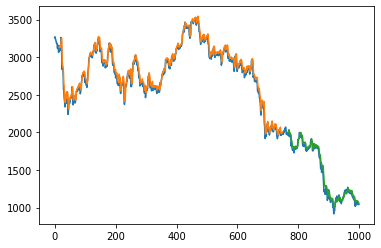

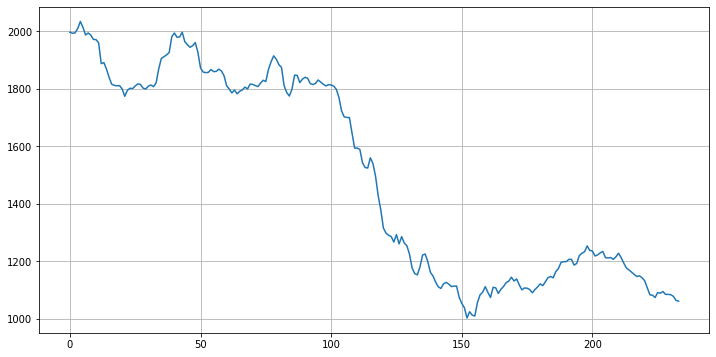

In [11]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(min_max_scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

plt.figure(figsize=(12, 6))
plt.plot(testPredict)
plt.grid(True)
plt.show()

## Plotting Real data


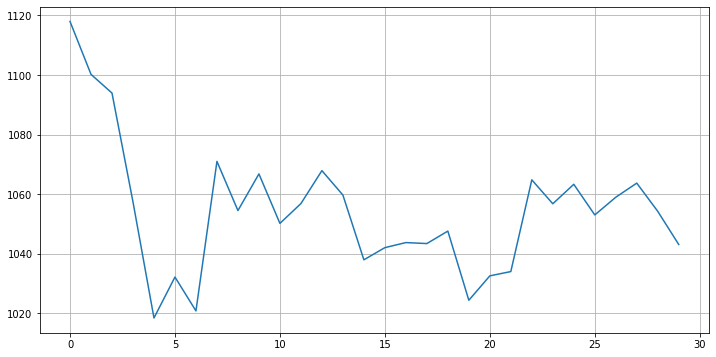

In [12]:
def create_next_datasett(dataset):
    next_dataset = []
    
    for i in range(look_back):
      next_dataset.append(dataset[len(dataset)-i-1])
    next_dataset = min_max_scaler.fit_transform(np.array(next_dataset).reshape(-1, 1))
    return np.array([(next_dataset)])

z = np.array(df['close'])[750:]

for i in range(0,12):
  test = create_next_datasett(z)
  test = np.reshape(test, (test.shape[0], 1, test.shape[1]))
  next_predictt = model.predict(test)
  z = np.append(z, min_max_scaler.inverse_transform(next_predictt)[0][0])

plt.figure(figsize=(12, 6))
plt.plot(z[len(z)-30:])
plt.grid(True)
plt.show()